# Business Objective

To help the average investor build a portfolio of stock and ensure maximum returns. Goals of the investor could range between short-term goals like saving for a dream vacation, down payment of a home etc. to long-term goals like saving for child's education, retirement etc.

# Methodology

1. Data of the chosen stock from 2017-2022 will be scraped from [Yahoo Finance](https://finance.yahoo.com/)  using python's  `yfinance`(documentation can be found [here](https://aroussi.com/post/python-yahoo-finance)) and `YahooFinancials` (documentation can be found [here](https://pypi.org/project/yahoofinancials/)).

2. Using the data, 4 commonly used metrics to evaluate a stock will be plotted: ***price,returns,beta and dividend***

3. Using an `ARIMA` model, stock price forecasts will then be made. This is just a mathematical model and is not guaranteed success. The model cannot account for black swan events and hence the investor must use his/her discretion when choosing a stock by doing more research of the company he/she plans to invest in. 

4. Combined with stock performance and forecast information, then by feeding the chosen stock into the optimizer, the investor can look at combined returns and decide which portfolio is best-aligned with his/her goals.



# Collecting stock data and plotting metrics to evaluate performance

In [1]:
import yfinance as yf 
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline
import numpy as np
import pandas as pd
import itertools
from datetime import date
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from scipy.signal._signaltools import _centered
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [2]:
#function to get stock data of a company

start_date = '2017-01-01'
end_date = '2022-12-31'

def stock_info(ticker):
    #get stock prices for the specified date ranges
    df = yf.download(ticker,start=start_date,end=end_date)
    #plot the stock price over the years
    fig,ax = plt.subplots(figsize=(15,5))
    ax.plot(df['Adj Close']);
    ax.set_title(f'Stock Price of {ticker} from 2017 to 2022')
    return ax
#---------------------------------------------------------------------------------------------------------

#function to calculate stock return

def stock_return(ticker):
    #get stock prices for the specified date ranges
    df = yf.download(ticker,start=start_date,end=end_date)
    df_return = df[['Adj Close']]
    df_return['pct_change'] = df_return['Adj Close'].pct_change() # use pct change to calculate the diff 
    df_return.drop(df_return.index[0],inplace=True) # drop the Nan value from the first row
    
    #plot the returns over 5 years
    fig,ax=plt.subplots(figsize=(15,5))
    ax.plot(df_return['pct_change']);
    plt.title('Stock Return Pct from 2017 to 2022:' +' ' + ticker)

#---------------------------------------------------------------------------------------------------------

#function to calculate beta value of stock

def calculate_beta(ticker):
    
    #get data for ticker and SPY whih serves as the market index
    symbols = [ticker,'SPY']
    data = yf.download(symbols, start = '2019-01-01',end = '2022-12-31')['Adj Close']
    price_change = data.pct_change()
    price_change.drop(price_change.index[0],inplace=True)
    
    #reshape for linear regression
    X = np.array(price_change[ticker]).reshape((-1,1))
    y = np.array(price_change['SPY'])

    #create splits
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    #predictions
    y_preds = lr.predict(X_test)

    #plot 
    fig,ax = plt.subplots(figsize=(8,8));
    ax.plot(X_test,y_preds,linestyle=':',color='orange')
    ax.scatter(y_test,y_preds,alpha=0.5)
    ax.set_title(f' Beta value = {lr.coef_}')
    ax.set_xlabel('Market Index:SPY')
    ax.set_ylabel(f'{ticker} value')
    plt.show();
    
    return ax
#---------------------------------------------------------------------------------------------------------

#function to get historical PE ratios

def get_pe_ratio(ticker):
    
    #get financial statement of ticker using yahoofinancials
    financials = YahooFinancials(ticker)
    statement = financials.get_financial_stmts('annual', 'income', reformat=True)    
    
    #create a dict of the income statement alone
    dicts ={}
    for i in statement['incomeStatementHistory'][ticker]:
        dicts.update(i)
    
    #create a dataframe for easy use
    df = pd.DataFrame(dicts)
    df = df.T
    df['dilutedAverageShares'].fillna(df['dilutedAverageShares'].median(),inplace=True)
    
    #calculate pe ratio
    eps = df['netIncomeContinuousOperations']/df['dilutedAverageShares'] #calc earnings per share
    eps_df = pd.DataFrame(eps,index=df.index,columns=['EPS'])
    eps_df['PE ratio'] = financials.get_current_price()/eps_df['EPS']#get current price and calc pe ratio
    
    #plot result
    fig,ax=plt.subplots(figsize=(8,8));
    ax.plot(eps_df['PE ratio'],marker = '*', markerfacecolor = 'black')
    ax.set_title(f'Historical PE ratio: {ticker}')
    ax.set_ylabel('PE ratio')
    plt.show()
    
    return ax
#---------------------------------------------------------------------------------------------------------

#function to get historical dividend data

def get_dividend(ticker):
    
    #get dividend data
    financials = YahooFinancials(ticker)
    div = financials.get_daily_dividend_data(start_date=start_date,end_date=end_date)
    
    #check if the company pays dividends
    if div[ticker] == None:
        fig,ax = plt.subplots(figsize=(5,5))
        ax.annotate(f'Sorry, {ticker} does not offer dividends',xy=(0.3,0.5),fontsize=20);
        ax.axis('off')
        return fig,ax
    
    else:#if company does pay dividends,then convert to a df and create a plot
        df = pd.DataFrame(div[ticker])
        df.drop('date',axis=1,inplace=True)
        df.rename(columns={'formatted_date':'date'},inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date',inplace=True)
        fig,ax=plt.subplots(figsize=(8,8))
        ax.plot(df['amount']);
        ax.set_title(f'Dividend rate: {ticker}');
        
    return ax
#---------------------------------------------------------------------------------------------------------

def summary_info(ticker):
    return stock_info(ticker),stock_return(ticker),calculate_beta(ticker),get_pe_ratio(ticker),get_dividend(ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


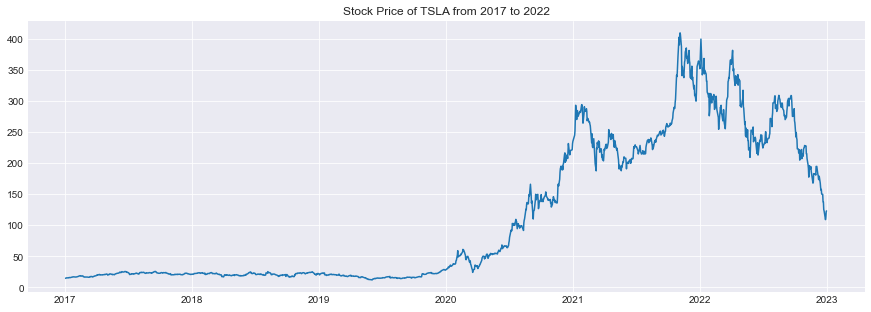

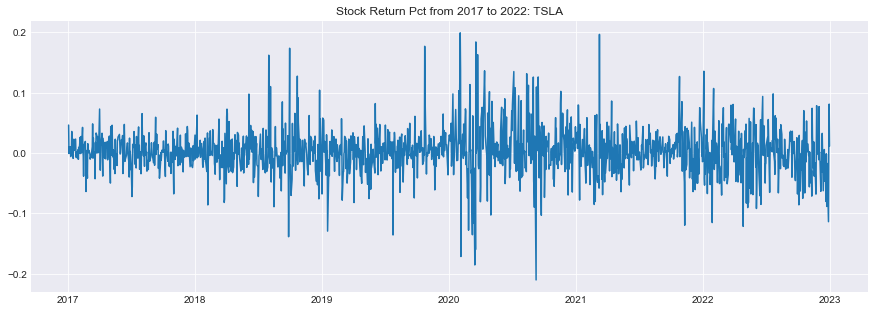

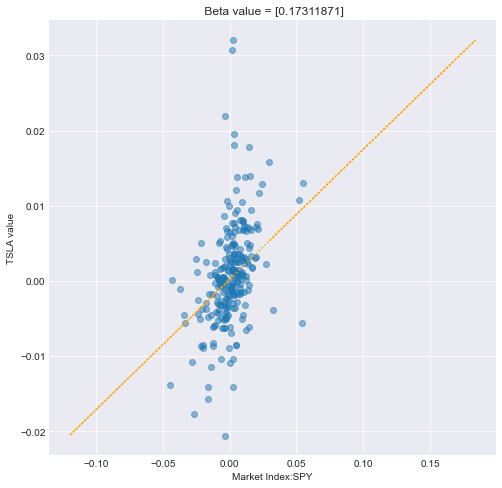

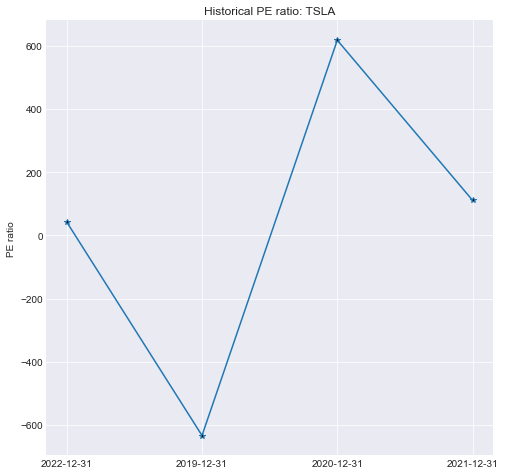

(<AxesSubplot:title={'center':'Stock Price of TSLA from 2017 to 2022'}>,
 None,
 <AxesSubplot:title={'center':' Beta value = [0.17311871]'}, xlabel='Market Index:SPY', ylabel='TSLA value'>,
 <AxesSubplot:title={'center':'Historical PE ratio: TSLA'}, ylabel='PE ratio'>,
 (<Figure size 360x360 with 1 Axes>, <AxesSubplot:>))

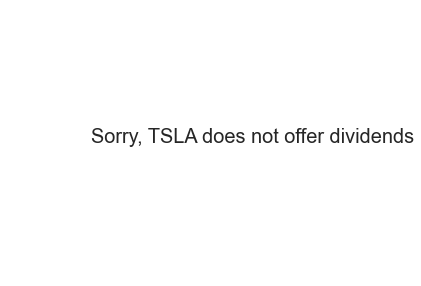

In [3]:
summary_info('TSLA')

# Time Series Modelling

## Stationarity Check

In [4]:
def plot_trends(ticker):
    df = yf.download(ticker,start=start_date,end=end_date)
    close = df.loc[:,['Adj Close']]

#compute rolling mean and std to see if they are constant
    roll_mean = close.rolling(window=30,center=False).mean()
    roll_std = close.rolling(window=30,center=False).std()

#plot the data
    fig,ax=plt.subplots(figsize=(15,5))
    ax.plot(close,color='blue',label='Original')
    ax.plot(roll_mean,color='red',label='Rolling Mean')
    ax.plot(roll_std,color='green',label='Rolling StdDev')
    ax.legend(loc='best')
    ax.set_title(f'Rolling Statistics of {ticker}');

#dickey Fuller Test
    dftest = adfuller(close['Adj Close'])
    dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'],columns=['Values'])
    
    return ax,dfoutput

## Convert non-stationary to stationary 

In [5]:
def differencing(ticker):
    df = yf.download(ticker,start=start_date,end=end_date)
    df_return = df[['Adj Close']]
    df_diff =df_return.diff(periods=1)
    df_diff.dropna(inplace=True)
    
    #plot the results
    fig,ax = plt.subplots(figsize = (12,8));
    ax.plot(df_diff, label = 'Differenced');
    ax.plot(df_diff.rolling(30).mean(),label = 'Rolling Mean')
    ax.plot(df_diff.rolling(30).std(),label = 'Rolling StdDev')
    ax.set_title(f'Differenced plot of {ticker}')
    ax.legend(loc=2);
    
    #dickey fuller test
    dftest = adfuller(df_diff['Adj Close'])
    dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'],columns=['Values'])
    
    return ax,dfoutput

##  ACF and PACF

[*********************100%***********************]  1 of 1 completed


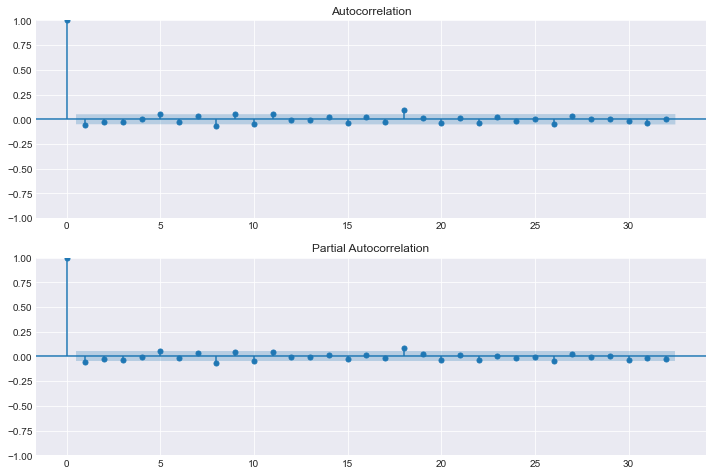

In [6]:
#get stock data
df = yf.download('AAPL',start=start_date,end=end_date)
df_close = df[['Adj Close']]
df_diff =df_close.diff(periods=1)
df_diff.dropna(inplace=True)

#plot ACF and PACF values
fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(12,8))
acf = plot_acf(df_diff,ax=ax1)
pacf = plot_pacf(df_diff,ax=ax2)

## ARIMA model

In [7]:
#defining train and test sets
cutoff= int(df_close.shape[0]*0.75)
train = df_close[:cutoff]
test = df_close[cutoff:]

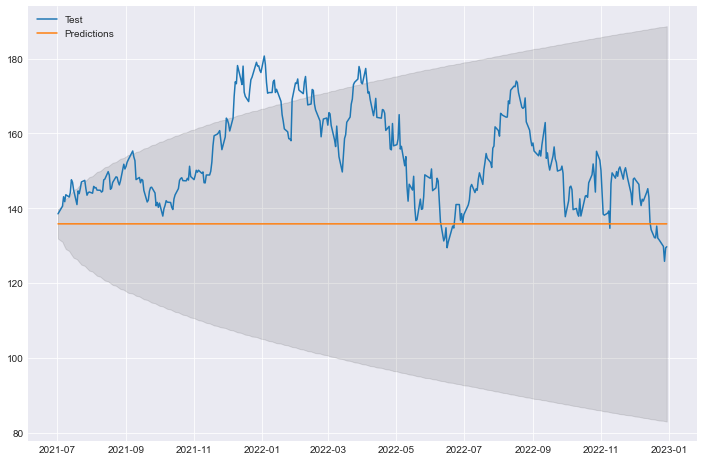

In [8]:
# (1,1,1) ARIMA(p,d,q) based on ACF and PACF plots
#instantiate
model = ARIMA(train,order=(1,1,1))

#fit
model_fit = model.fit()
# print(model_fit.summary())

#getting predictions using get_prediction method
arima_predictions = model_fit.get_prediction(start = 1133, end = 1510,dynamic=True)
#predicted_mean gives lists the values
arima_pred_price=arima_predictions.predicted_mean
#converting into a df
arima_pred_price_df = pd.DataFrame(data=arima_pred_price)
#seetting the index to the test dates
arima_pred_price_df.index= test.index

# arima_pred_price_df.head()

#confidence intervals of predictions
arima_conf_int = arima_predictions.conf_int()
arima_conf_int.set_index(test.index,inplace=True)

# arima_conf_int.head()

#plotting predictions with confidence intervals
fig,ax =plt.subplots(figsize=(12,8))
# ax.plot(train,label='Train');
ax.plot(test,label='Test');
ax.plot(arima_pred_price_df,label='Predictions');
# ax.plot(arima_conf_int,label='Confidence Intervals')
ax.fill_between(arima_conf_int.index,arima_conf_int.iloc[:,0],arima_conf_int.iloc[:,1],color='k',alpha=0.1);
ax.legend(loc=2);

In [9]:
#RMSE
error_arima = round(np.sqrt(mean_squared_error(test,arima_pred_price_df)),2)
print(f'RMSE of the model is {error_arima}')

RMSE of the model is 21.26


## SARIMA model

In [10]:
p=d=q=range(0,2)
pdq = list(itertools.product(p,d,q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [11]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(train,
                          order=comb,
                          seasonal_order=combs,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('SARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

SARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=12889.28182754176
SARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=11331.756163741466
SARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=6746.681986521415
SARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=6676.737312337098
SARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=6697.483534656606
SARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=6692.905091140017
SARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=6683.528323925894
SARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=6677.529858525577
SARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=11358.944283669145
SARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=9846.150415876384
SARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=5845.3245152332265
SARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=5792.696036212102
SARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=5819.572089507374
SARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=5820.585632005648
SARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=5803.18224

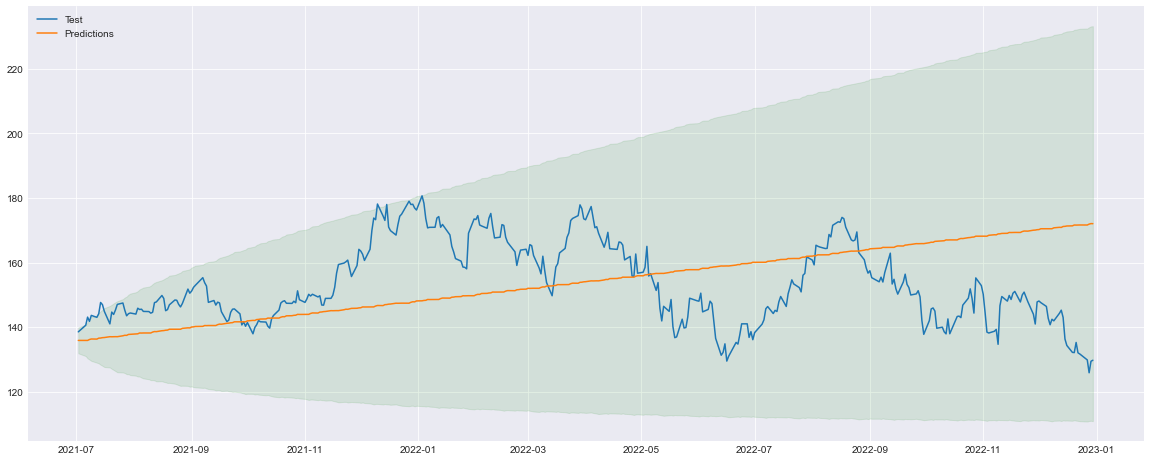

In [12]:
# Plug the optimal parameter values into a new SARIMAX model
sarimax = SARIMAX(train, 
                  order=(1,1,1), 
                  seasonal_order=(1 ,1, 1, 12), 
                  enforce_stationarity=False, 
                  enforce_invertibility=False)

# Fit the model and print results
output = sarimax.fit()

#get predictions
sarimax_predictions = output.get_prediction(start=1133,end=1510,dynamic=True)
sarimax_price=sarimax_predictions.predicted_mean
sarimax_predictions_df = pd.DataFrame(data=sarimax_price)
sarimax_predictions_df.index= test.index

#get confidence intervals
sarimax_conf_int = sarimax_predictions.conf_int()
sarimax_conf_int.set_index(test.index,inplace=True)

#plot results
fig,ax =plt.subplots(figsize=(20,8))
# ax.plot(train,label='Train');
ax.plot(test,label='Test');
ax.plot(sarimax_predictions_df,label='Predictions');
# ax.plot(sarimax_conf_int,label='Confidence Intervals')
ax.fill_between(sarimax_conf_int.index,sarimax_conf_int.iloc[:,0],sarimax_conf_int.iloc[:,1],color='g',alpha=0.1);
ax.legend(loc=2);

In [13]:
#RMSE
error_sarima = round(np.sqrt(mean_squared_error(test,sarimax_predictions_df)),2)
print(f'RMSE of the model is {error_sarima}')

RMSE of the model is 17.19


## Facebook prophet

In [14]:
#get stock data
df = yf.download('AAPL',start=start_date,end=end_date)
df_close = df[['Adj Close']]

#resmapling by weekly
df_weekly = df_close.resample('W').mean()

[*********************100%***********************]  1 of 1 completed


In [15]:
#setting up df to be able to run Prophet

#reset index
df_weekly.reset_index(inplace=True)

#rename columns per prophet conventions
df_weekly.rename(columns={'Adj Close': 'y',
                         'Date':'ds'},inplace=True)

#set the date as the index
# df_close.set_index('ds',inplace=True)
df_weekly.head()

,ds,y
0,2017-01-08,27.255385
1,2017-01-15,27.852367
2,2017-01-22,28.019277
3,2017-01-29,28.304624
4,2017-02-05,29.403511


In [16]:
#defining train and test sets
cutoff= int(df_weekly.shape[0]*0.75)
train = df_weekly[:cutoff]
test = df_weekly[cutoff:]

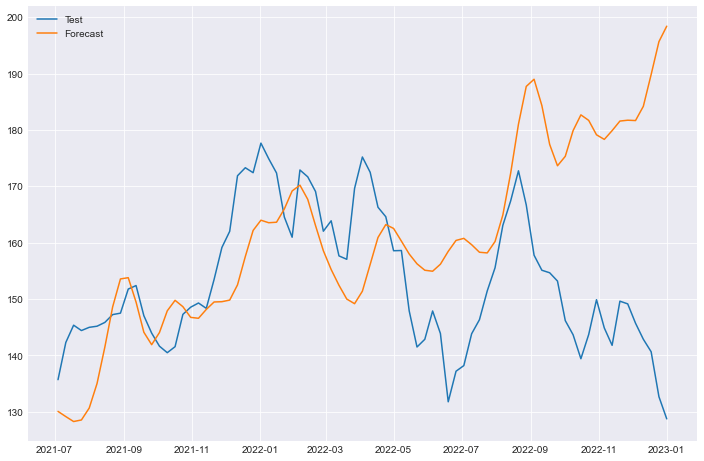

In [17]:
#instantiate
m = Prophet(seasonality_mode='multiplicative',
            weekly_seasonality=True,
            daily_seasonality = True,
            yearly_seasonality = True,
            interval_width=0.90, 
           )

#fit
m.fit(train)

#forecasts - creating future dates using in built make_future_dataframe method
future = m.make_future_dataframe(periods=79,freq='W',include_history=False)

#predicting yhat 
forecast = m.predict(future)

#creating a df of predicted values
forecast_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(79)

#set the index for the plots
forecast_values.set_index('ds',inplace=True)
test.set_index('ds',inplace=True)

#plotting results
fig,ax=plt.subplots(figsize=(12,8))
# ax.plot(train,label='Train')
ax.plot(test,label='Test')
# ax.plot(df_weekly,label='Current Price')
ax.plot(forecast_values['yhat'],label='Forecast')
# ax.fill_between(test.index,forecast_values['yhat_lower'],forecast_values['yhat_upper'],color='g',alpha=0.1);
ax.legend();

In [18]:
#RMSE
error_fb = round(np.sqrt(mean_squared_error(test,forecast_values['yhat'])),2)
print(f'RMSE of the model is {error_fb}')

RMSE of the model is 21.26


In [19]:
# #run a loop for different regularization values

seasonality_scale = [0.1, 0.2, 0.3, 0.4, 0.5]
changepoint_scale = [0.1, 0.2, 0.3, 0.4, 0.5]
errors = []
for season in seasonality_scale:
    for changepoint in changepoint_scale:
        #instantiate
        m = Prophet(seasonality_mode='multiplicative',
                weekly_seasonality=True,
                daily_seasonality = True,
                yearly_seasonality = True,
                interval_width=0.90,
                seasonality_prior_scale=season,
                changepoint_prior_scale=changepoint
               )

        #fit
        m.fit(train)
        
        #forecasts - creating future dates using in built make_future_dataframe method
        future = m.make_future_dataframe(periods=79,freq='W',include_history=False)

        #predicting yhat 
        forecast = m.predict(future)

        #getting only yhat values
        forecast_values = forecast[['ds', 'yhat']].tail(79)
        
        #setting the index
        forecast_values.set_index('ds',inplace=True)

        #rmse values
        rmse = round(np.sqrt(mean_squared_error(test,forecast_values['yhat'])),3)
        errors.append(rmse)
        print(f'seasonality_scale:{season}, changepoint_scale:{changepoint}, rmse:{rmse}')
        
print('----------------------------------------------')
print(f'Smallest RMSE after looping is {min(errors)}')
print(f'Original RMSE is {error_fb}')

seasonality_scale:0.1, changepoint_scale:0.1, rmse:24.19
seasonality_scale:0.1, changepoint_scale:0.2, rmse:22.1
seasonality_scale:0.1, changepoint_scale:0.3, rmse:21.273
seasonality_scale:0.1, changepoint_scale:0.4, rmse:21.647
seasonality_scale:0.1, changepoint_scale:0.5, rmse:22.995
seasonality_scale:0.2, changepoint_scale:0.1, rmse:22.212
seasonality_scale:0.2, changepoint_scale:0.2, rmse:21.384
seasonality_scale:0.2, changepoint_scale:0.3, rmse:22.748
seasonality_scale:0.2, changepoint_scale:0.4, rmse:24.918
seasonality_scale:0.2, changepoint_scale:0.5, rmse:25.283
seasonality_scale:0.3, changepoint_scale:0.1, rmse:21.769
seasonality_scale:0.3, changepoint_scale:0.2, rmse:22.452
seasonality_scale:0.3, changepoint_scale:0.3, rmse:24.353
seasonality_scale:0.3, changepoint_scale:0.4, rmse:26.81
seasonality_scale:0.3, changepoint_scale:0.5, rmse:28.391
seasonality_scale:0.4, changepoint_scale:0.1, rmse:21.147
seasonality_scale:0.4, changepoint_scale:0.2, rmse:22.328
seasonality_scale:

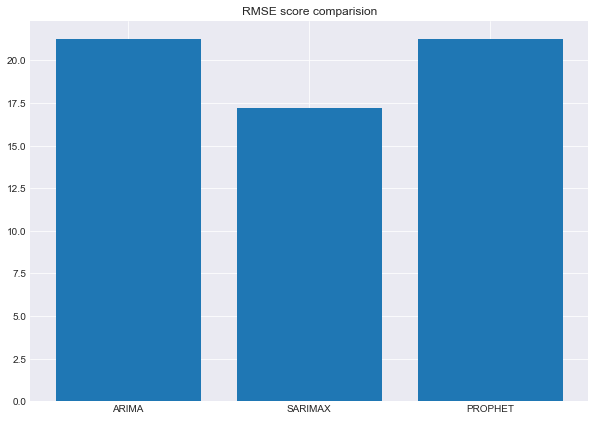

In [20]:
fig,ax =plt.subplots(figsize=(10,7))
ax.bar(x=['ARIMA', 'SARIMAX', 'PROPHET'],height=[error_arima,error_sarima,error_fb]);
ax.set_title('RMSE score comparision');


Since the sarimax model has the least RMSE score, we will use that going forward

## prophet with differencing - comparing with test

[*********************100%***********************]  1 of 1 completed
RMSE of the model is 6.44


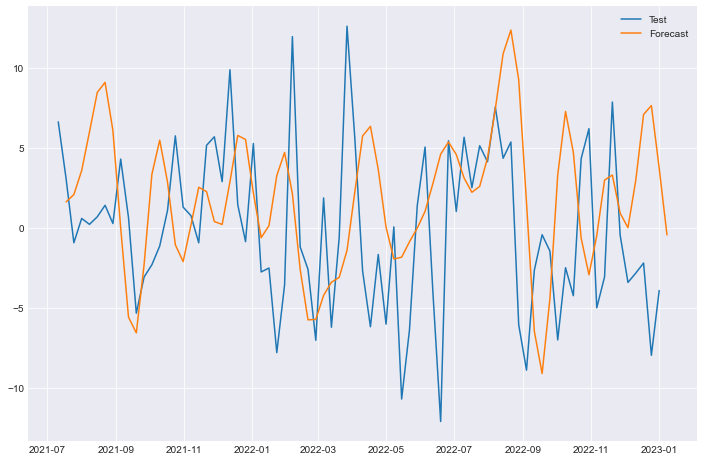

In [21]:
#get stock data
df = yf.download('AAPL',start=start_date,end=end_date)
df_close = df[['Adj Close']]

#resmapling by weekly
df_weekly = df_close.resample('W').mean()

df_weekly = df_weekly.diff(periods=1)
df_weekly.dropna(inplace=True)

#setting up df to be able to run Prophet

#reset index
df_weekly.reset_index(inplace=True)

#rename columns per prophet conventions
df_weekly.rename(columns={'Adj Close': 'y',
                         'Date':'ds'},inplace=True)

#set the date as the index
# df_close.set_index('ds',inplace=True)
# df_weekly.head()#setting up df to be able to run Prophet

#defining train and test sets
cutoff= int(df_weekly.shape[0]*0.75)
train = df_weekly[:cutoff]
test = df_weekly[cutoff:]

#instantiate
m = Prophet(seasonality_mode='multiplicative',
            weekly_seasonality=True,
            daily_seasonality = True,
            yearly_seasonality = True,
            interval_width=0.90, 
           )

#fit
m.fit(train)

#forecasts - creating future dates using in built make_future_dataframe method
future = m.make_future_dataframe(periods=79,freq='W',include_history=False)

#predicting yhat 
forecast = m.predict(future)

#creating a df of predicted values
forecast_values = forecast[['ds', 'yhat']].tail(78)

#set the index for the plots
forecast_values.set_index('ds',inplace=True)
test.set_index('ds',inplace=True)

#plotting results
fig,ax=plt.subplots(figsize=(12,8))
# ax.plot(train,label='Train')
ax.plot(test,label='Test')
# ax.plot(df_weekly,label='Current Price')
ax.plot(forecast_values['yhat'],label='Forecast')
# ax.fill_between(test.index,forecast_values['yhat_lower'],forecast_values['yhat_upper'],color='g',alpha=0.1);
ax.legend();

error_fb = round(np.sqrt(mean_squared_error(test,forecast_values['yhat'])),2)
print(f'RMSE of the model is {error_fb}')

## prophet with differencing whole dataset to get forecast - how to interpret values?

[*********************100%***********************]  1 of 1 completed


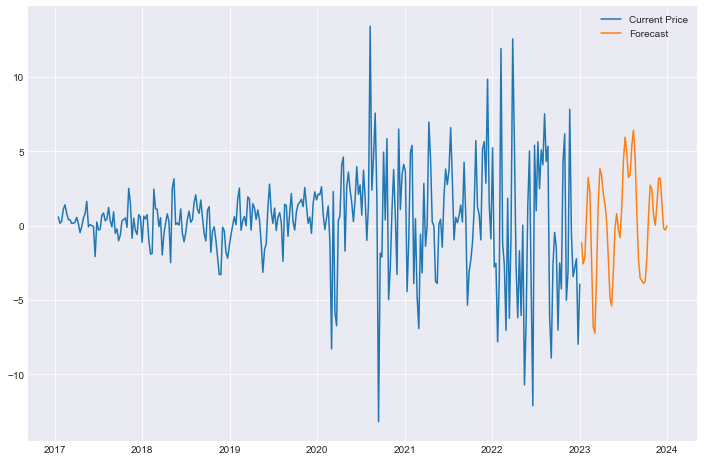

In [22]:
#get stock data
df = yf.download('AAPL',start=start_date,end=end_date)
df_close = df[['Adj Close']]

#resmapling by weekly
df_weekly = df_close.resample('W').mean()

df_weekly = df_weekly.diff(periods=1)
df_weekly.dropna(inplace=True)

#setting up df to be able to run Prophet

#reset index
df_weekly.reset_index(inplace=True)

#rename columns per prophet conventions
df_weekly.rename(columns={'Adj Close': 'y',
                         'Date':'ds'},inplace=True)

#set the date as the index
# df_close.set_index('ds',inplace=True)
# df_weekly.head()#setting up df to be able to run Prophet

#instantiate
m = Prophet(seasonality_mode='multiplicative',
            weekly_seasonality=True,
            daily_seasonality = True,
            yearly_seasonality = True,
            interval_width=0.90, 
           )

#fit
m.fit(df_weekly)

#forecasts - creating future dates using in built make_future_dataframe method
future = m.make_future_dataframe(periods=52,freq='W',include_history=False)

#predicting yhat 
forecast = m.predict(future)

#creating a df of predicted values
forecast_values = forecast[['ds', 'yhat']].tail(78)

#set the index for the plots
forecast_values.set_index('ds',inplace=True)
df_weekly.set_index('ds',inplace=True)

#plotting results
fig,ax=plt.subplots(figsize=(12,8))
# ax.plot(train,label='Train')
ax.plot(df_weekly,label='Current Price')
# ax.plot(df_weekly,label='Current Price')
ax.plot(forecast_values['yhat'],label='Forecast')
# ax.fill_between(test.index,forecast_values['yhat_lower'],forecast_values['yhat_upper'],color='g',alpha=0.1);
ax.legend();

# Predictions using sarimax

In [23]:
def get_predictions(ticker):
    df = yf.download(ticker,start=start_date,end=end_date)
    df_close = df[['Adj Close']]
    
    # SARIMAX model
    sarimax = SARIMAX(df_close, 
                  order=(1,1,1), 
                  seasonal_order=(1 ,1, 1, 12), 
                  enforce_stationarity=False, 
                  enforce_invertibility=False)

    # Fit the model and print results
    output = sarimax.fit()
    
    #get predictions
    predictions = output.get_prediction(start=1510,end=1873,dynamic=True)
    predicted_price=predictions.predicted_mean
    
    #create dates for the predictions
    new_dates = pd.date_range(start = '2023-01-01', end = '2023-12-30')
    
    #create df for easy plotting
    price_df = pd.DataFrame(data=predicted_price)
    price_df.set_index(new_dates,inplace=True)
    
    #plotting
    fig,ax = plt.subplots(figsize=(12,8))
    ax.plot(df_close,label='Current Price')
    ax.plot(price_df,label='Predicted Price')
    ax.set_title(f'Predicted Price of {ticker}');
    ax.legend();
    
    return ax

# Building Portfolio

In [58]:
def get_current_price(ticker):
    df = yf.download(ticker,start='2023-04-06')
    ticker_df = df[['Adj Close']]
    current_price = round(float(ticker_df.iloc[0]),2)
    
    return current_price

In [25]:
def get_forecast_price(ticker):
    df = yf.download(ticker,start=start_date,end=end_date)
    df_close = df[['Adj Close']]
    
    # SARIMAX model
    sarimax = SARIMAX(df_close, 
                  order=(1,1,1), 
                  seasonal_order=(1 ,1, 1, 12), 
                  enforce_stationarity=False, 
                  enforce_invertibility=False)

    # Fit the model and print results
    output = sarimax.fit()
    
    #get predictions
    predictions = output.get_prediction(start=1510,end=1873,dynamic=True)
    predicted_price=predictions.predicted_mean
    
    #create dates for the predictions
    new_dates = pd.date_range(start = '2023-01-01', end = '2023-12-30')
    
    #create df for easy plotting
    price_df = pd.DataFrame(data=predicted_price)
    price_df.set_index(new_dates,inplace=True)
    
    #get the last value
    last_price = round(float(price_df.iloc[-1]),2)
    
    return last_price

In [113]:
percents

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [111]:
def portfolio(amount,stocks):
    amount = amount
    stocks = stocks
    percents = np.arange(0.05,1,0.05)
    
    stock1_current_price = get_current_price(stocks[0])
    stock2_current_price = get_current_price(stocks[1])
    
    stock1_sell_price = get_forecast_price(stocks[0])
    stock2_sell_price = get_forecast_price(stocks[1])
    
    for i in percents:
        stock1_invest_amount = round(i*1000)
        stock2_invest_amount = amount - stock1_invest_amount
        
        if (stock1_invest_amount > stock1_current_price) & (stock2_invest_amount > stock2_current_price):
            stock1_shares = round(stock1_invest_amount/stock1_current_price,1)
            stock2_shares = round(stock2_invest_amount/stock2_current_price,1)

            
            stock1_aftersale_amount = round(stock1_shares*stock1_sell_price,2)
            stock2_aftersale_amount = round(stock2_shares*stock2_sell_price,2)
            
            stock1_return = round(stock1_aftersale_amount/stock1_invest_amount - 1,3)
            stock2_return = round(stock2_aftersale_amount/stock2_invest_amount - 1,3)
            
            stock1_prop = stock1_invest_amount/amount
            stock2_prop = stock2_invest_amount/amount
            
            portfolio_return = round((stock1_prop*stock1_return) + (stock2_prop*stock2_return),4)
            portfolio_return_pct = round(portfolio_return*100,2)
            
            print(f'investments:{stocks[0]}: ${stock1_invest_amount}, {stocks[1]}: ${stock2_invest_amount}')
#             print(f'shares: {stock1_shares,stock2_shares}')
#             print(f'sales: {stock1_aftersale_amount,stock2_aftersale_amount}')
#             print(f'returns: {stock1_return,stock2_return}')
#             print(f'proportions: {stock1_prop,stock2_prop}')
            print(f'total returns: {portfolio_return_pct}%')
            print('\n')

In [112]:
portfolio(1000,['SCHD','O'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
investments:SCHD: $100, O: $900
total returns: 8.0%


investments:SCHD: $150, O: $850
total returns: 8.55%


investments:SCHD: $200, O: $800
total returns: 8.26%


investments:SCHD: $250, O: $750
total returns: 8.8%


investments:SCHD: $300, O: $700
total returns: 9.36%


investments:SCHD: $350, O: $650
total returns: 9.91%


investments:SCHD: $400, O: $600
total returns: 10.46%


investments:SCHD: $450, O: $550
total returns: 11.0%


investments:SCHD: $500, O: $500
total returns: 11.55%


investments:SCHD: $550, O: $450
total returns: 11.25%


investments:SCHD: $600, O: $400
total returns: 11.82%


investments:SCHD: $650, O: $350
total returns: 12.36%


investments:SCHD: $700, O: $300
total returns: 12.92%


inves